<div align='center'><font size="6" color="#F39C12">Getting started with Natural Language Processing</font></div>
<div align='center'><font size="5" color="#F39C12">A general Introduction</font></div>
<hr>


<p style='text-align:justify'><b>Key Objectives:</b>This notebook comes as a first part to the **Getting started with NLP Notebooks** that I am writing. This notebook explains the concepts of NLP with respect to this current competition. NLP is the field of study that focuses on the interactions between human language and computers. NLP sits at the intersection of computer science, artificial intelligence, and computational linguistics[[source](https://en.wikipedia.org/wiki/Natural_language_processing)]. NLP is a way for computers to analyze, understand, and derive meaning from human language in a smart and useful way.</p>

<b>Notebooks in this series</b>

  <ul>
      <li><a href="https://www.kaggle.com/parulpandey/getting-started-with-nlp" target="_blank">Part 1: Getting started with NLP : A General Introduction </a></li>
      <li><a href="https://www.kaggle.com/parulpandey/getting-started-with-nlp-2-countvectorizer" target="_blank">Part 2: Getting started with NLP: Part 2 - CountVectorizers | TFIDF | Hashing Vectorizer </a></li></ul>

<hr>

Another notebook based on text processing is : [Basic preprocessing and EDA](https://www.kaggle.com/parulpandey/basic-preprocessing-and-eda/edit/run/31248388) based on the [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction)

## Dataset
The datasets contains a set of tweets which have been divided into a training and a test set. The training set contains a target column identifying whether the tweet pertains to a real disasteror not.

Our job is to create a ML model to predict whether the test set tweets belong to a disaster or not, in the form of 1 or 0.This is a classic case of a Binary Classification problem. 

source: https://deepai.org/machine-learning-glossary-and-terms/f-score          

# Table of Contents
* [1. Importing the necessary libraries](#imports)
- [2. Reading the datasets](#reading)
- [3. Basic EDA](#eda)
- [4. Text data processing](#processing)
- [5. Transforming tokens to vectors](#vectorization)
- [6. Buiding a Text Classification model](#model)

# <a name="imports"></a>1. Importing the necessary libraries

In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 600.4 kB/s eta 0:00:00m eta 0:00:010:00:17
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
nltk.download("all")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/talal/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/talal/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/talal/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/talal/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/talal/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /home/talal/nltk_data

# <a name="reading"></a> 2. Reading the datasets

In [5]:
#Training data
train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data has 7613 observations and 5 features including the TARGET (the label we want to predict).

In [6]:
# Testing data 
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Note the test data doesn't have the target column

# <a name="eda"></a> 3. Basic EDA

## Missing values

In [7]:
#Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The columns denote the following: 

- The `text` of a tweet
- A `keyword` from that tweet
- The `location` the tweet was sent from

In [8]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

A lot of values are missing in the `location` column in both the training and the testing set.

## Exploring the Target Column

* ** Distribution of the Target Column**

We have to predict whether a given tweet is about a real disaster or not. - If so, predict a 1. If not, predict a 0.

In [11]:
train['target'].value_counts().index

Index([0, 1], dtype='int64', name='target')

<Axes: xlabel='target', ylabel='count'>

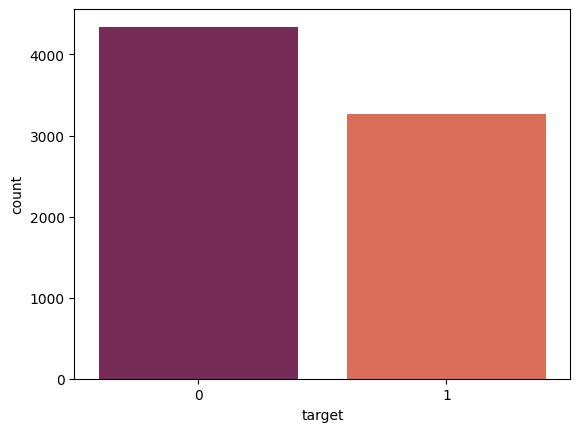

In [10]:
sns.barplot(x=train['target'].value_counts().index,y=train['target'].value_counts(),palette='rocket')

* **Exploring the Target Column**
Let's look at what the disaster and the non disaster tweets look like

In [12]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

## Exploring the 'keyword' column
The keyword column denotes a keyword from the tweet.Let's look at the top 20 keywords in the training data

In [15]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [16]:
train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

<Axes: xlabel='keyword', ylabel='count'>

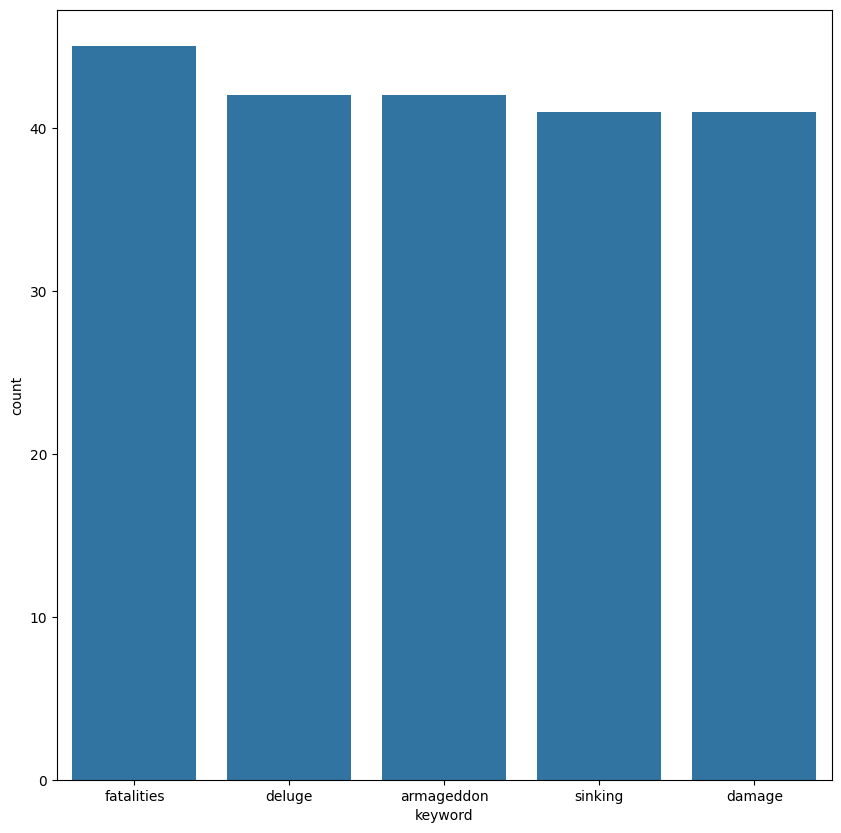

In [23]:
plt.figure(figsize=(10,10))
sns.barplot(x=train['keyword'].value_counts()[:5].index,y=train['keyword'].value_counts()[:5],)

Let's see how often the word 'disaster' come in the dataset and whether this help us in determining whether a tweet belongs to a disaster category or not.

In [25]:
train.loc[]

id                                                          1
keyword                                                   NaN
location                                                  NaN
text        Our Deeds are the Reason of this #earthquake M...
target                                                      1
Name: 0, dtype: object

In [28]:
train['text'].str.contains('disaster', na=False, case=False)

0       False
1       False
2       False
3       False
4       False
        ...  
7608    False
7609    False
7610    False
7611    False
7612    False
Name: text, Length: 7613, dtype: bool

In [13]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

## Exploring the 'location' column
Even though the column `location` has a number of missing values, let's see the top 20 locations present in the dataset. Since some of the locations are repeated, this will require some bit of cleaning.

In [ ]:
x = 10
x = x+10

<Axes: xlabel='count', ylabel='location'>

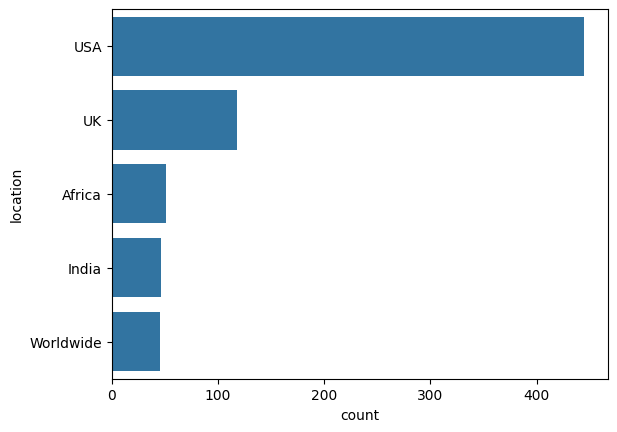

In [29]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

In [ ]:
words = ["history","historian"] -> history

In [ ]:
"hi are u okay ?" ->  hi:0, are, u, okay, ?


> # <a name="processing"></a> 4. Text Data Preprocessing

## 1. Data Cleaning

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the  basic text pre-processing techniques includes:

* Make text all **lower case** or **uppercase** so that the algorithm does not treat the same words in different cases as different
* **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values,  common non-sensical text (/n)
* **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
* **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:

* **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
* **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
* Parts of speech tagging
* Create bi-grams or tri-grams
And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled : [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.Xi2BhhczZTY) that summarizes how much preprocessing you should be performing on your text data:

![](https://kavita-ganesan.com/wp-content/uploads/2019/02/Screen-Shot-2019-02-23-at-1.36.52-PM-590x270.png)

In [32]:
# A quick glance over the existing data
text = train['text'][:5][0]

In [34]:
text = text.lower() +" aosdhfks [8238]"

re.sub('\[.*?\]', '', text)


'our deeds are the reason of this #earthquake may allah forgive us all aosdhfks '

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Just for fun let's create a wordcloud of the clean text to see the most dominating words in the tweets.

In [37]:
train['text'][0]

'our deeds are the reason of this earthquake may allah forgive us all'

In [16]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 622.3 kB/s eta 0:00:001m619.7 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
" ".join(disaster_tweets)

"Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all Forest fire near La Ronge Sask. Canada All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 13,000 people receive #wildfires evacuation orders in California  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas I'm on top of the hill and I can see a fire in the woods... There's an emergency evacuation happening now in the building across the street I'm afraid that the tornado is coming to our area... Three people died from the heat wave so far Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding #raining #flooding #Florida

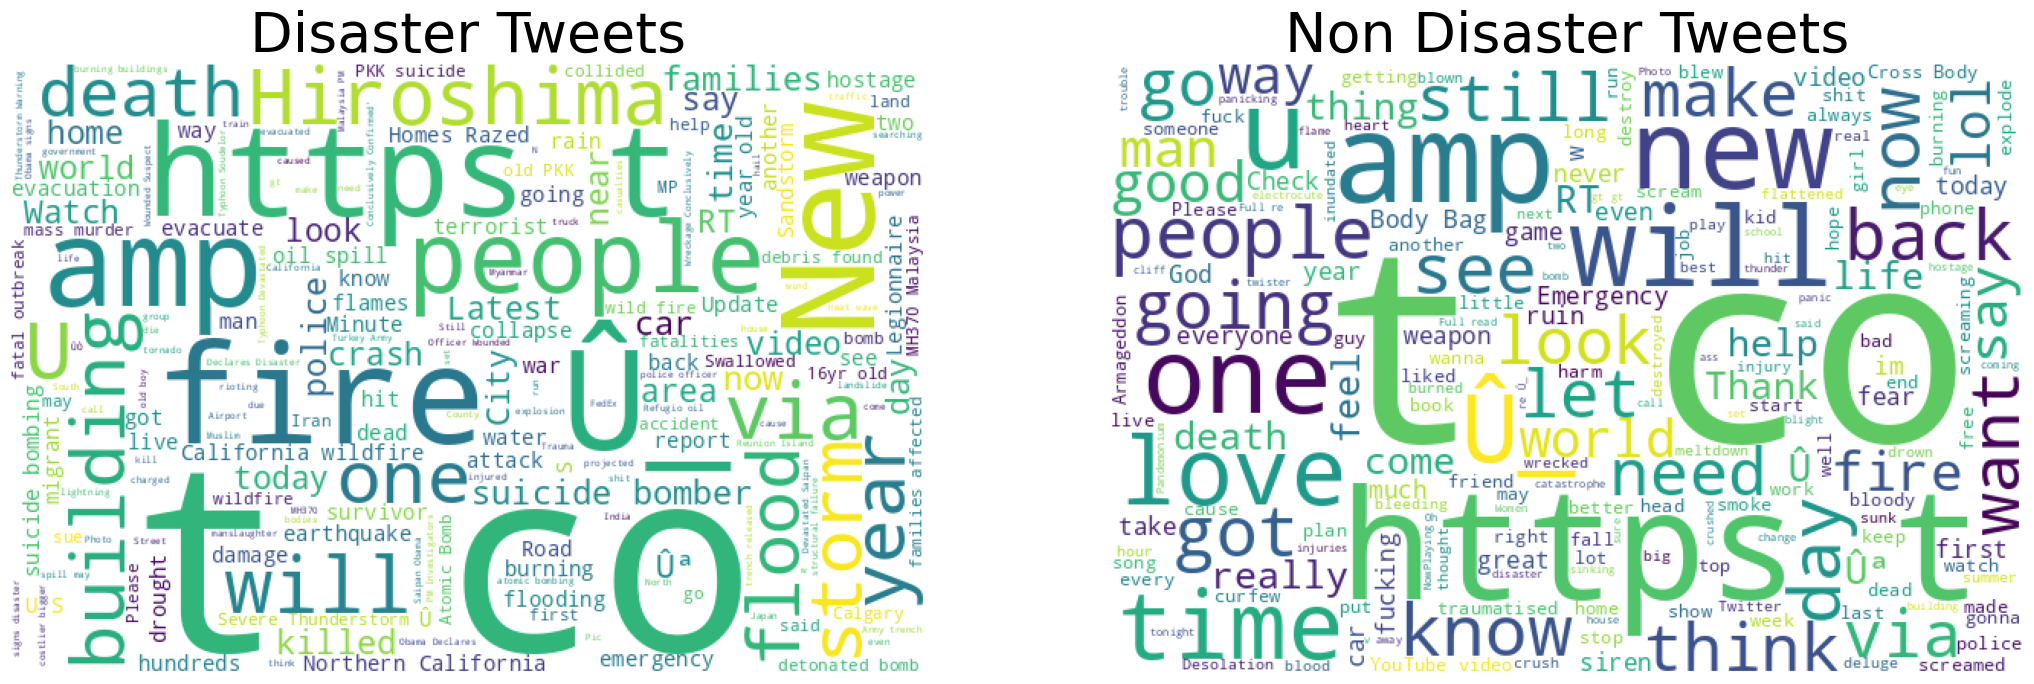

In [17]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

## 2. Tokenization

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. Base upon the type of tokens we want, tokenization can be of various types, for instance

In [40]:
import nltk
# nltk.download("punkt")
from nltk.tokenize import sent_tokenize, word_tokenize 

text = "Natural Language Processing (NLP) is a field at the intersection of computer science, artificial intelligence, and linguistics, focused on enabling computers to understand, interpret, and generate human language in a meaningful way. NLP encompasses a range of techniques and technologies that allow computers to process and analyze large volumes of natural language data, from speech recognition and machine translation to sentiment analysis and chatbots. The ultimate goal of NLP is to create systems that can communicate with humans in their own languages, extracting or providing information, answering questions, and even mimicking human conversational patterns. As such, NLP is fundamental to developing more intuitive and effective human-computer interactions, powering applications in various domains including healthcare, customer service, education, and legal analysis."


print(sent_tokenize(text)) 
print(word_tokenize(text))

['Natural Language Processing (NLP) is a field at the intersection of computer science, artificial intelligence, and linguistics, focused on enabling computers to understand, interpret, and generate human language in a meaningful way.', 'NLP encompasses a range of techniques and technologies that allow computers to process and analyze large volumes of natural language data, from speech recognition and machine translation to sentiment analysis and chatbots.', 'The ultimate goal of NLP is to create systems that can communicate with humans in their own languages, extracting or providing information, answering questions, and even mimicking human conversational patterns.', 'As such, NLP is fundamental to developing more intuitive and effective human-computer interactions, powering applications in various domains including healthcare, customer service, education, and legal analysis.']
['Natural', 'Language', 'Processing', '(', 'NLP', ')', 'is', 'a', 'field', 'at', 'the', 'intersection', 'of'

In [41]:
# Tokenizing the training and the test set

train['text'] = train['text'].apply(lambda x: word_tokenize(x))
test['text'] = test['text'].apply(lambda x: word_tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [42]:
train['text'][0]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

## 3. Stopwords Removal

Now, let's get rid of the stopwords i.e words which occur very frequently but have no possible value like **a, an, the, are **etc.

In [43]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [44]:
# nltk.download("stopwords")
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

[nltk_data] Downloading package stopwords to /home/talal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

## 4. Token normalization

Token normalisation means converting different tokens to their base forms. This can be done either by:

- **Stemming** :  removing and replacing suffixes to get to the root form of the word, which is called the **stem** for instance cats - cat, wolves - wolv 
- **Lemmatization** : Returns the base or dictionary form of a word, which is known as the **lemma** 

[*source*](https://www.coursera.org/learn/language-processing/lecture/SCd4G/text-preprocessing)

In [28]:
nltk.download()
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokens = word_tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


It is important to note here that stemming and lemmatization sometimes donot necessarily improve results as at times we donot want to trim words but rather preserve their original form. Hence their usage actually differs from problem to problem. For this problem, I will not use these techniques.

In [21]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


### Getting it all together- A Text Preprocessing Function
This concludes the pre-processing part. It will be prudent to convert all the steps undertaken into a function for better reusability.

In [22]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

# <a name="vectorization"></a>  5. Transforming tokens to a vector
After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. This can be done by a number of tecniques:

## Bag of Words

The bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words.
- A measure of the presence of known words.

Why is it is called a “bag” of words? That is because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

For example, 

![](https://imgur.com/jWqtRP1.png)

*source:[Natural Language Processing course on coursera](https://www.coursera.org/learn/language-processing/home/welcome)*

We can do this using scikit-learn's CountVectorizer, where every row will represent a different tweet and every column will represent a different word.

### Bag of Words - Countvectorizer Features

[Countvectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.However, i did all the process manually above to just get a better understanding. Let's use a vanilla implementation of the countvectorizer without specifying any parameters.


In [23]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


### TFIDF Features

A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

**Term Frequency: is a scoring of the frequency of the word in the current document.**

```
TF = (Number of times term t appears in a document)/(Number of terms in the document)
```

**Inverse Document Frequency: is a scoring of how rare the word is across documents.**

```
IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
```

In [24]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])


# <a name="model"></a> 6. Building a Text Classification model
Now the data is ready to be fed into a classification model. Let's create a basic claasification model using commonly used classification algorithms and see how our model performs.

## Logistic Regression Classifier

In [25]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.59865255, 0.50301464, 0.57118787, 0.5669145 , 0.68888889])

In [26]:
clf.fit(train_vectors, train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57258065, 0.49626866, 0.54277829, 0.46618106, 0.64768683])

It appears the countvectorizer gives a better performance than TFIDF in this case.

## Naives Bayes Classifier
Well, this is a decent score. Let's try with another model that is said to work well with text data : Naive Bayes.

In [28]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63324979, 0.60688666, 0.68718683, 0.64341085, 0.72505092])

In [29]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57067603, 0.61188811, 0.5962963 , 0.7393745 ])

well the naive bayes on TFIDF features scores much better than logistic regression model. 

In [31]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## XGBoost

In [32]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.46775956, 0.384689  , 0.4330855 , 0.38900634, 0.53142857])

In [33]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores



array([0.47533632, 0.32510288, 0.42830189, 0.40084388, 0.53014354])